# 1. Introduction and Imports

## 1.1. Problem Overview

The [Titanic competition in Kaggle](https://www.kaggle.com/competitions/titanic) is a classic binary classification problem among beginners in the Data Science & Machine Learning world.

It is based on the horrible Titanic disaster which took place in 1912: the biggest ship at that time sank due to a collision with an iceberg, leaving thousands of deaths behind.

Our goal is to predict whether a list of passengers survived or not.

Based on what we know, we assume the highest survival rates will be among women, children and wealthy passangers.

The Competition evaluates predictions based on accuracy, so we will use the same metric for model validation.

## 1.2. Datasets Description

We are given two datasets:

- The **training data** conatains a list of passengers with useful information and their survival status.
- The **testing data** is for making predictions and submit them on the Competition.

## 1.3. Library Imports

Let's import all the libraries we will use.

In [59]:
#Data handling
import numpy as np
import pandas as pd

#Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

#Preprocessing and pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Classification models
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Evaluation metrics and tools
from sklearn.metrics import accuracy_score, confusion_matrix , ConfusionMatrixDisplay, roc_curve, auc

# 2. Load and Explore Data

## 2.1. Load Data

The following code reads the training and testing data and saves it as a Pandas DataFrame.

In [60]:
#Load data
df_train = pd.read_csv("/kaggle/input/titanic-df/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic-df/test.csv")

## 2.2. Data Inspection

In [61]:
#Look at first rows of the data
print("Training data:")
display(df_train.head())
print("\n")
print("Testing data:")
display(df_test.head())

Training data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S




Testing data:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Looking at the description on the Competition website we find out what the information on all the columns is:

- **PassengerId** is a unique Id for each passenger.
- **Surivived** tells us whether that passenger survived the sinking or not - 1 means Yes and 0 means No.
- **Pclass** is the ticket class the passenger had - 1st class, 2nd class or 3rd class.
- **Name**, **Sex** and **Age** are self-explanatory.
- **SibSp** is the number of siblings or spouses the passenger had aboard the Titanic.
- **Parch** is the number of parents or children the passenger had aboard the Titanic.
- **Ticket**, **Fare** and **Cabin** are also self-explanatory.
- **Embarked** refers to the port of embarkation - C is Cherbourg, Q is Queenstown and S is Southampton.

## 2.3. Missing Values

In [62]:
#Inspect missing values
print("MISSING VALUES - PERCENTAGE")
print("Training data:")
display(100* (df_train.isna().sum() / df_train.shape[0]))
print("\n")
print("Testing data:")
display(100* (df_test.isna().sum() / df_test.shape[0]))

MISSING VALUES - PERCENTAGE
Training data:


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64



Testing data:


PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

On the training data there are a lot of missing values for **Cabin**. We also have some missing values for **Age**, and very few for **Embarked**.

On the testing data we also have a lot of missing values for **Cabin**, some missing values for **Age** and very few for **Fare**.

Having so many missing values for **Cabin** makes it worth considering dropping that column.

All of these missing values will need to be dealt with.

## 2.4. Survival Rate Distribution

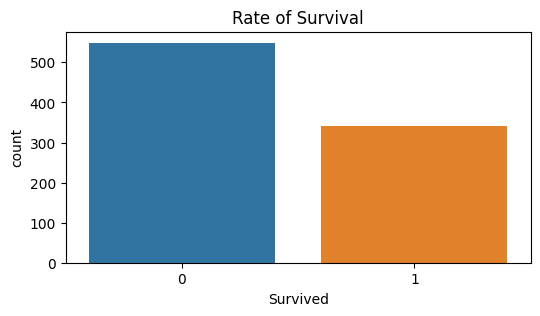

In [63]:
#Plot survival distribution
plt.figure(figsize=(6, 3))
sns.countplot(data=df_train, x='Survived')
plt.title('Rate of Survival')
plt.show()

We see that most passengers didn't survive the sinking of the Titanic.

The difference between the number of passengers who survived and the ones who died is around two hunded.

## 2.5. Categorical Features Analysis

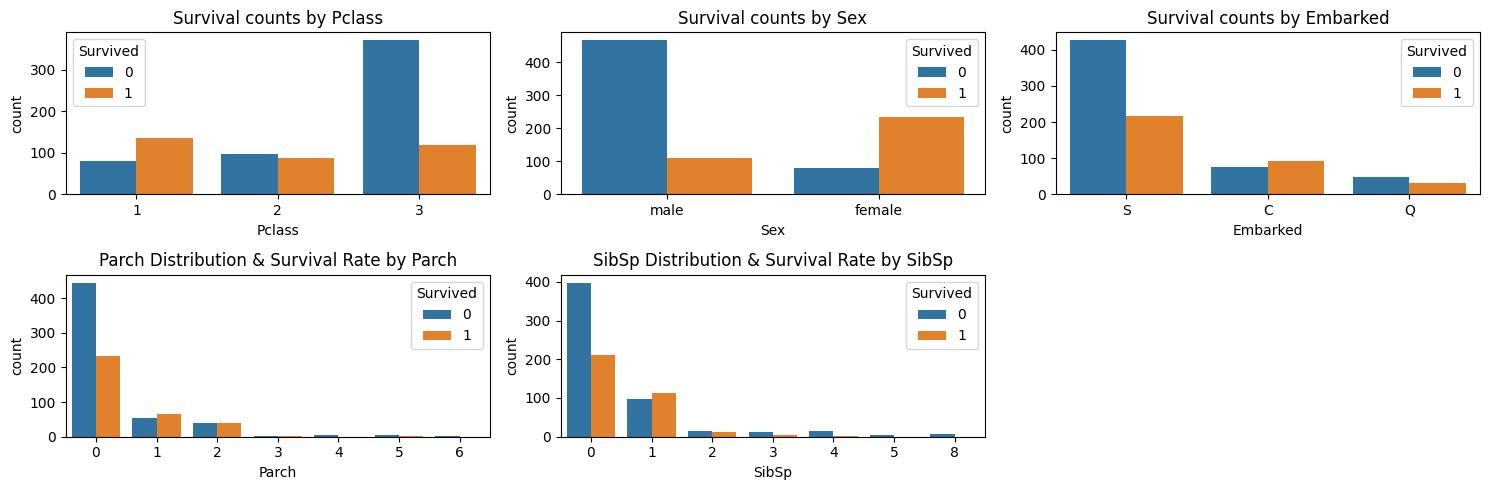

In [64]:
#Plot categorical features distributions and survival rates
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

sns.countplot(data=df_train, x='Pclass', hue='Survived', ax=axs[0, 0])
axs[0, 0].set_title('Survival counts by Pclass')

sns.countplot(data=df_train, x='Sex', hue='Survived', ax=axs[0, 1])
axs[0, 1].set_title('Survival counts by Sex')

sns.countplot(data=df_train, x='Embarked', hue='Survived', ax=axs[0, 2])
axs[0, 2].set_title('Survival counts by Embarked')

sns.countplot(data=df_train, x='Parch', hue='Survived', ax=axs[1, 0])
axs[1, 0].set_title('Parch Distribution & Survival Rate by Parch')

sns.countplot(data=df_train, x='SibSp', hue='Survived', ax=axs[1, 1])
axs[1, 1].set_title('SibSp Distribution & Survival Rate by SibSp')

fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

- We see the lowest rate of survival among third class passengers, and the highest one among first class passengers.
- As we hypothesized in section 1, rate of survival is very low among men and very high among women.
- We see a very low rate of survival among passengers who embarked on Southampton.
- We also see a low rate of survival among passengers who traveled alone and a higher one among those who had parents/children or siblings/spouses aboard.

## 2.6. Numerical Features Analysis

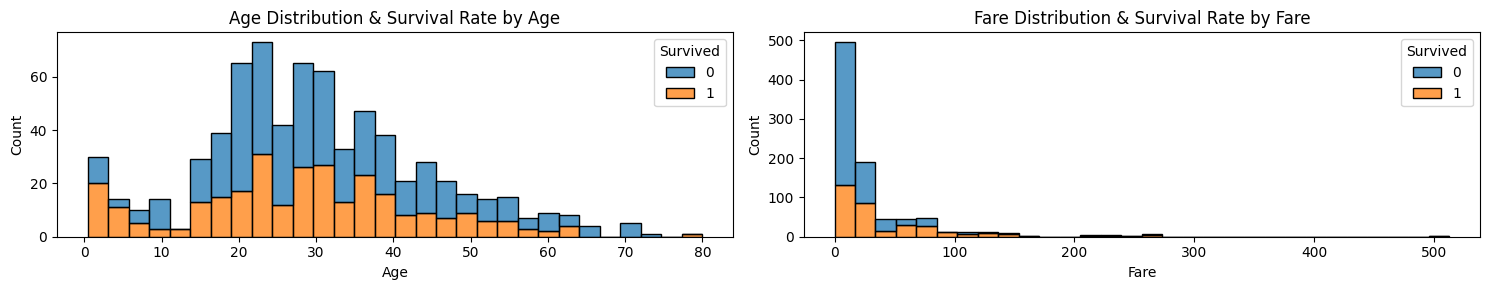

In [65]:
#Plot numerical features distribution and survival rates
warnings.simplefilter(action='ignore', category=FutureWarning)

fig, axs = plt.subplots(1, 2, figsize=(15, 3))

sns.histplot(data=df_train, x='Age', hue='Survived', bins=30, multiple='stack', ax=axs[0])
axs[0].set_title('Age Distribution & Survival Rate by Age')

sns.histplot(data=df_train, x='Fare', hue='Survived', bins=30, multiple='stack', ax=axs[1])
axs[1].set_title('Fare Distribution & Survival Rate by Fare')

plt.tight_layout()
plt.show()

- Children aged 5 years and less have the highest survival rate of all passengers. The survival rate among other passengers doesn't change significantly. Most passengers were aged between 20 to 40.
- As we hypothesized, wealthy passangers have a highest rate of survival. Most passengers with low fare died. As fare increases, so does survival rate.

## 2.7. Correlation Analysis

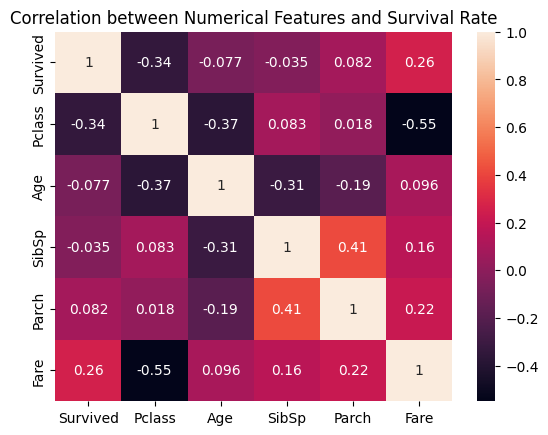

In [66]:
#Numerical and categorical features before feature engineering
pre_numerical_cols = [cols for cols in df_train.columns if (df_train[cols].dtype in ['float', 'int']) and not(cols  in ['PassengerId', 'Survived'])]
pre_categorical_cols = [cols for cols in df_train.columns if (df_train[cols].dtype == 'object') and not(cols  in ['PassengerId', 'Survived'])]

#Correlation matrix
sns.heatmap(data=df_train[['Survived'] + pre_numerical_cols].corr(), annot=True)
plt.title('Correlation between Numerical Features and Survival Rate')
plt.show()

- We see a relatively high positive correlation between **Fare** and **Survived**. It makes sense: the higher the fare, the higher the chance of survival.
- We also see a very negative correlation between **Pclass** and **Survived**. Intuitively, first class passengers have a higher chance of survival and as class goes up, survival rate goes down.

## 2.8. EDA Summary and Insights

We have found that the features that have a greater affect on survival rate are the following:

- **Sex**. High survival rate among women and low survival rate among men.
- **Pclass**. First class passengers have a high survival rate while third class passengers have lowest survival rate.
- **Fare**. Survival rate is directly correlated with wealth - wealthier passengers have a higher chance of survival.
- **Parch** & **SibSp**. Passenger who traveled alone have a very low chance of surviving.

# 3. Data Preprocessing

## 3.1. Data Cleaning

We will now set **PassengerId** as the index for both the training and testing DataFrames.

We will also drop columns we do not need like **Name** and **Ticket**.

The **Cabin** column will also be dropped because of its large amount of missing values.

In [67]:
#Set index
df_train = df_train.set_index('PassengerId')
df_test = df_test.set_index('PassengerId')

#Drop columns
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

## 3.2. Feature Engineering

Next we will create a couple of features that might be useful to predict our target:

- We will add a feature counting **FamilySize** for each passenger.
- **IsAlone** will tell us whether that passenger's family size is exactly 1.

In [68]:
#Create FamilySize feature
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp'] + 1
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp'] + 1

#Create IsAlone feature
df_train['IsAlone'] = (df_train['FamilySize'] == 1).astype(int)
df_test['IsAlone'] = (df_test['FamilySize'] == 1).astype(int)

## 3.3. Train and Validation Split

Next we will create a DataFrame called X containing the features we will use to make predictions.

The Pandas Series y will contain the target, **Survived**.

We will split the training data into two subsets: one will be used for model training and the other one for model validation.

In [69]:
#Create target and features
y = df_train['Survived']
X = df_train.drop(['Survived'], axis=1)

#Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

#Supress RuntimeWarning
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in.*",
    category=RuntimeWarning,
    module="pandas.io.formats.format"
)

#Look at first rows of training set
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
PassengerId,,,,,,,,,
141,3,female,NaN,0,2,15.2458,C,3,0
440,2,male,31.0,0,0,10.5000,S,1,1
818,2,male,31.0,1,1,37.0042,C,3,0
379,3,male,20.0,0,0,4.0125,C,1,1
492,3,male,21.0,0,0,7.2500,S,1,1


## 3.4. Preprocessing Pipeline

Now we will make use of a pipeline to impute missing values and One Hot encode categorical features.

A median strategy will be used for imputing numerical values and a most frequent strategy for categorical values.

In [70]:
#Define categorical columns and numerical columns
numerical_cols = [cols for cols in X.columns if X[cols].dtype in ['float', 'int']]
categorical_cols = [cols for cols in X.columns if X[cols].dtype in ['object']]

#Numerical transformer
numerical_transformer = SimpleImputer(strategy='median')

#Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

#Define our pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

#Fit pipeline on the training data
preprocessor.fit(X_train)

#Transform our features
X_train_pro = pd.DataFrame(preprocessor.transform(X_train),  columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_valid_pro = pd.DataFrame(preprocessor.transform(X_valid), columns=preprocessor.get_feature_names_out(), index=X_valid.index)
df_test_pro = pd.DataFrame(preprocessor.transform(df_test), columns=preprocessor.get_feature_names_out(),index=df_test.index)

# 4. Modeling and Evaluation

## 4.1. Model Definitions

In this step we will define three different models that perform well on binary classification problems with structured data.

These are eXtreme Gradient Boosting (XGB), Random Forests and Logistic Regression.

We will use early stopping rounds for the XGB model to prevent overfitting.

In [71]:
#Define models
xgb = XGBClassifier(random_state=0, early_stopping_rounds=10);
random_forest = RandomForestClassifier(random_state=0);
logistic_regression = LogisticRegression(random_state=0);

## 4.2. Cross-Validation

For an initial comparison before hyperparemeter tuning, we will do cross-validation in the training set.

In [72]:
#Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

#Cross validation in training set
xgb_accuracy = cross_val_score(xgb, X_train_pro, y_train, cv=5, scoring='accuracy',
                               fit_params={'eval_set': [(X_valid_pro, y_valid)], 'verbose': False})
random_forest_accuracy = cross_val_score(random_forest, X_train_pro, y_train, cv=5, scoring='accuracy')
logistic_regression_accuracy = cross_val_score(logistic_regression, X_train_pro, y_train, cv=5, scoring='accuracy')

#Print results
print("XGB Cross-Validation Mean Accuracy: {}".format(xgb_accuracy.mean()))
print("Random Forest Cross-Validation Mean Accuracy: {}".format(random_forest_accuracy.mean()))
print("Logistic Regression Cross-Validation Mean Accuracy: {}".format(logistic_regression_accuracy.mean()))

XGB Cross-Validation Mean Accuracy: 0.8314488328572835
Random Forest Cross-Validation Mean Accuracy: 0.7837486457204768
Logistic Regression Cross-Validation Mean Accuracy: 0.7991726583275879


## 4.3. Hyperparameter Tuning

In this step we will do a grid search using cross-validation to find good parameters for each of our models.

In [73]:
#Ignore UserWarning
warnings.simplefilter(action='ignore', category=UserWarning)

#Grid search for XGB
xgb_search = GridSearchCV(estimator=xgb,
                          param_grid={'n_estimators': [100, 200, 500],
                                      'max_depth': [3, 6, 10],
                                      'learning_rate': [0.01, 0.1, 0.3]},
                          scoring='accuracy')
xgb_search.fit(X_train_pro, y_train, eval_set=[(X_valid_pro, y_valid)], verbose=False)

#Grid search for Random Forest
random_forest_search = GridSearchCV(estimator=random_forest, 
                                    param_grid={'n_estimators': [100, 200, 500],
                                                'max_depth': [None, 10, 20]},
                                    scoring='accuracy')
random_forest_search.fit(X_train_pro, y_train)

#Grid search for Logistic Regression
logistic_regression_search = GridSearchCV(estimator=logistic_regression,
                                          param_grid={'max_iter': [100, 500, 1000],
                                                      'C': [0.1, 1, 10],
                                                      'solver': ['liblinear', 'lbfgs', 'saga']},
                                          scoring='accuracy')
logistic_regression_search.fit(X_train_pro, y_train)

#Get the best models
xgb_model = xgb_search.best_estimator_
random_forest_model = random_forest_search.best_estimator_
logistic_regression_model = logistic_regression_search.best_estimator_

#Loot at the best parameters
print("XGB best parameters:", xgb_search.best_params_)
print("Random Forest best parameters:", random_forest_search.best_params_)
print("Logistic Regression best parameters:", logistic_regression_search.best_params_)

XGB best parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}
Random Forest best parameters: {'max_depth': 10, 'n_estimators': 500}
Logistic Regression best parameters: {'C': 0.1, 'max_iter': 500, 'solver': 'lbfgs'}


## 4.4. Model Validation

### 4.4.1. Accuracy Score

In [74]:
#Make predictions
xgb_preds = xgb_model.predict(X_valid_pro)
random_forest_preds = random_forest_model.predict(X_valid_pro)
logistic_regression_preds = logistic_regression_model.predict(X_valid_pro)

#Get accuracy
xgb_accuracy = accuracy_score(y_valid, xgb_preds)
random_forest_accuracy = accuracy_score(y_valid, random_forest_preds)
logistic_regression_accuracy = accuracy_score(y_valid, logistic_regression_preds)

#Print accuracy
print("XGB model accuracy on evaluation data: {}".format(xgb_accuracy))
print("Random Forest model accuracy on evaluation data: {}".format(random_forest_accuracy))
print("Logistic Regression model accuracy on evaluation data: {}".format(logistic_regression_accuracy))

XGB model accuracy on evaluation data: 0.8547486033519553
Random Forest model accuracy on evaluation data: 0.8547486033519553
Logistic Regression model accuracy on evaluation data: 0.7988826815642458


The models that performed best are XGB and Random Forest while the Logistic Regression model stays slightly behind.

We see that hyperamarameter tuning improved the performance of the XGB and Random Forest models.

### 4.4.2. Confusion Matrix

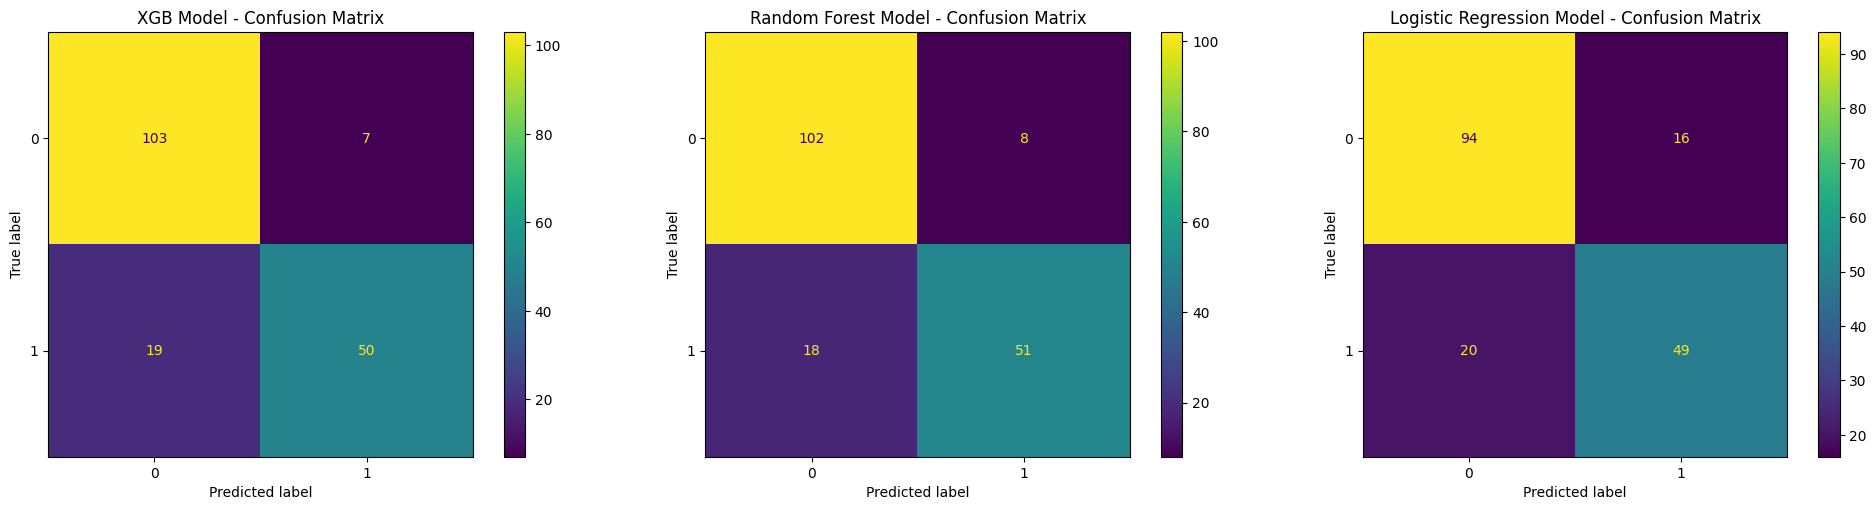

In [75]:
#Plot confusion matrixes
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

cm_xgb = confusion_matrix(y_valid, xgb_preds)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb).plot(ax=axs[0])
axs[0].set_title("XGB Model - Confusion Matrix")

cm_random_forest = confusion_matrix(y_valid, random_forest_preds)
disp_random_forest = ConfusionMatrixDisplay(confusion_matrix=cm_random_forest).plot(ax=axs[1])
axs[1].set_title("Random Forest Model - Confusion Matrix")

cm_logistic_regression = confusion_matrix(y_valid, logistic_regression_preds)
disp_logistic_regression = ConfusionMatrixDisplay(confusion_matrix=cm_logistic_regression).plot(ax=axs[2])
axs[2].set_title("Logistic Regression Model - Confusion Matrix")

plt.tight_layout()
plt.show()

The results indicate that we got:

- 19 false negatives using the XGB model.
- 18 false negatives using the Random Forest model.
- 20 false negatives using the Logistic Regression model.

These are passengers that the predictions say did not survive, when in fact they did survive.

Let's look at the false positives we got:

- 7 false positives using the XGB model.
- 8 false positives using the Random Forest model.
- 16 false positives using the Logistic Regression model.

These are passengers that the predictions say did survive, when in fact they did not survive.

We notice XGB got very low false positives, which explains its high accuracy in the validation data.

The Logistic Regression model did a lot of mistakes for both, which explains why it got the lowest accuracy of all.

### 4.4.3. ROC Curves and AUC Scores

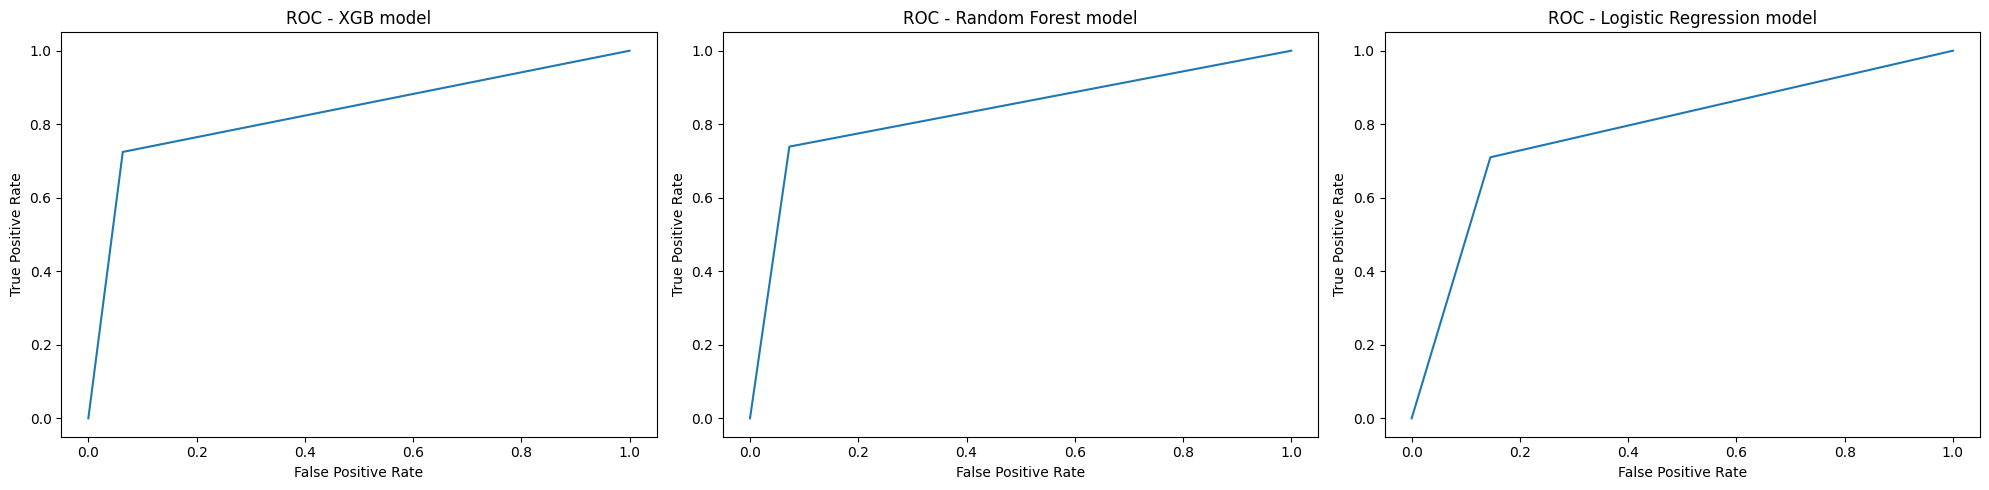



XGB model AUC score: 0.8305006587615285
Random Forest model AUC score: 0.833201581027668
Logistic Regression model AUC score: 0.7823451910408431


In [76]:
#Get ROC curve and AUC score for XGB
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, xgb_preds)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#Get ROC curve and AUC score for Random Forest
fpr_random_forest, tpr_random_forest, _ = roc_curve(y_valid, random_forest_preds)
roc_auc_random_forest = auc(fpr_random_forest, tpr_random_forest)

#Get ROC curve and AUC score for Logistic Regression
fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(y_valid, logistic_regression_preds)
roc_auc_logistic_regression = auc(fpr_logistic_regression, tpr_logistic_regression)

#Plot ROC curves
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(fpr_xgb, tpr_xgb)
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC - XGB model')

axs[1].plot(fpr_random_forest, tpr_random_forest)
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC - Random Forest model')

axs[2].plot(fpr_logistic_regression, tpr_logistic_regression)
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].set_title('ROC - Logistic Regression model')

plt.tight_layout()
plt.show()

#Print AUC scores
print("\n")
print("XGB model AUC score: {}".format(roc_auc_xgb))
print("Random Forest model AUC score: {}".format(roc_auc_random_forest))
print("Logistic Regression model AUC score: {}".format(roc_auc_logistic_regression))

Remember that the ROC curve plots the True Positive Rate against the False Positive Rate when varying the classification threshold.

The AUC score is the area below the ROC curve.

The AUC score of the Random Forest model is slightly better than that of the XGB model, while Logistic Regression stays behind.

## 4.5. Model Performance Summary

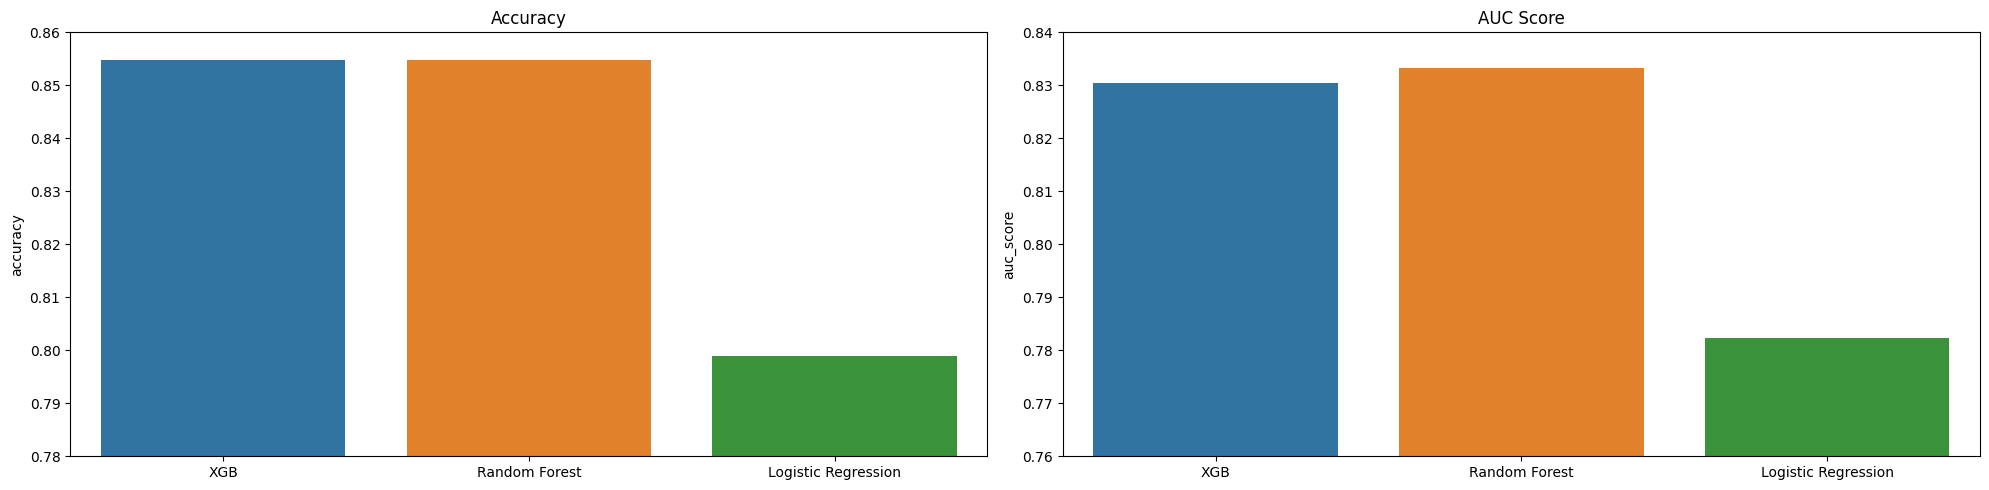

In [77]:
#Create scores Pandas DataFrame
scores = pd.DataFrame({'accuracy': [xgb_accuracy, random_forest_accuracy, logistic_regression_accuracy],
                      'auc_score': [roc_auc_xgb, roc_auc_random_forest, roc_auc_logistic_regression]},
                      index=['XGB', 'Random Forest', 'Logistic Regression'])

#Plot
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x=scores.index, y=scores.accuracy, ax=axs[0])
axs[0].set_ylim([0.78, 0.86])
axs[0].set_title('Accuracy')

sns.barplot(x=scores.index, y=scores.auc_score, ax=axs[1])
axs[1].set_ylim([0.76, 0.84])
axs[1].set_title('AUC Score')

plt.tight_layout()
plt.show()

Since we got both the highest accuracy in the validation set and the highest AUC score with the Random Forest model, that is the model we will use to make the predictions for the Competition.

This is surprising because XGB usually performs better than XGB.

This could be due to the nature of the relationships between the target and the features, which could be captured better by the Random Forest model.

Another reason could be because the dataset is small - we only have information for 891 passengers in the training data.

# 5. Prediction and Submission

## 5.1. Final Model Retraining on Full Data

Before making predictions for the testing data we will fit the Random Forest model on the full training data.

In [78]:
#Preprocess full training data
X_pro = pd.DataFrame(preprocessor.transform(X),  columns=preprocessor.get_feature_names_out(), index=X.index)

#Fit Random Forest on full training data
random_forest_search.fit(X_pro, y)
final_model = random_forest_search.best_estimator_

#Look at best parameters
print("Best parameters:", random_forest_search.best_params_)

Best parameters: {'max_depth': 10, 'n_estimators': 500}


## 5.2. Test Data Prediction and Submission File

Now we will make predictions on the testing data and create the submission file for the competition.

In [79]:
output = pd.DataFrame({'PassengerId': df_test.index, 'Survived': final_model.predict(df_test_pro)})
output.to_csv('submission.csv', index=False)

## 5.3. Feature Importance of Final Model

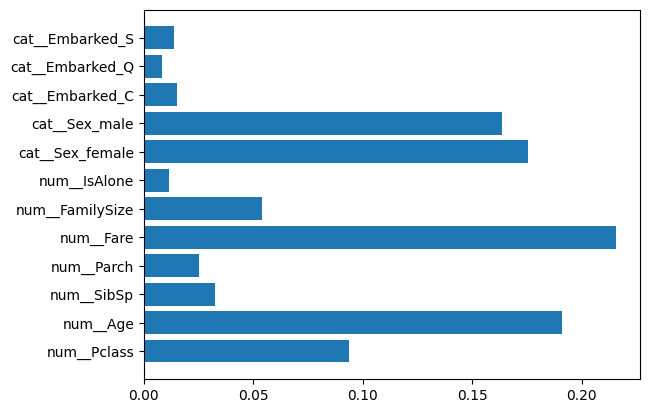

In [80]:
features = list(X_pro.columns)
importances = list(final_model.feature_importances_)
plt.barh(y=features, width=importances)
plt.show()

The results match our hypothesis very well.

In order, the features that our Random Forest model considered most important are: **Fare**, **Age**, **Sex**, **Pclass** and **FamilySize**.

We did not predict that **Age** would be so important though.

In section 2 we observed that children had a significantly higher rate of survival.

This information was certainly captured by our model.

## 5.4. Conclusions and Learnings

The most important features to predict whether a passenger survived or not in the Titanic sinking, and how they do so are as follow:

- **Fare**. Wealth is directly correlated to survival rate.
- **Age**. Children had a high chance of surviving. Beyond children, age doesn't seem to affect survival rate that much though.
- **Sex**. Women had significantly higher chances of surviving than men.
- **Pclass**. The highest rate of survival is seen among first class passengers. Third class passengers had the lowest chances of surviving.
- **Family size** is directly correlated to survival rate.

We used a Random Forest model, which slightly outperformed XGB, while Logistic Regression stayed behind.

This is surprising because XGB usually performs better than Random Forest.

This could be happening for a couple reasons:

- The nature of the relationships between the target and the features.
- The dataset is small.

All in all, this was my first project and I am very happy how it went.

This simple classifying problem served just as an introduction to supervised learning, and I hope to do more complicated projects in the future.

Thanks for reading!